In [1]:
import anndata as ad
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import re
import scipy
from scipy import sparse
import os
import scipy.stats as stats

from matplotlib import rcParams
from tqdm import tqdm

from scipy.stats import pearsonr


import warnings
warnings.filterwarnings("ignore")

In [2]:
def get_btm_df_withPvalues(stim_df_1, stim_df_2, module):
    hallmark_ifna = ["CMTR1","HERC6", "IFIH1", "IFIT2", "OASL", "IRF7", "DDX60", "CNP", "RSAD2", "TMEM140", "OAS1", "PARP14", "TRIM5", "EIF2AK2", "LGALS3BP", "TRIM21", "STAT2", "PNPT1", "HELZ2", "USP18", "TXNIP", "GBP4", "RTP4", "TRAFD1", "MOV10",
                 "LY6E", "IFI35", "MX1", "ISG20", "CXCL11", "IFIT3", "SAMD9", "PARP12", "DHX58", "LPAR6", "IFITM3", "SELL", "ADAR", "TRIM25", "SP110", "NUB1", "IRF2", "GMPR", "ELF1"]

    hallmark_tnf = ["GEM", "CCL20", "MSC", "IL23A", "CD80", "TUBB2A", "IL1A", "IL6", "FOSL1", "DUSP4", "INHBA", "PLAU", "CD83",
                "F3", "CXCL2", "EDN1", "GFPT2","TRAF1", "SOCS3", "RCAN1","ZC3H12A", "PMEPA1", "SPSB1", "GADD45B", "GADD45A", "BTG3",
                "PPP1R15A", "SERPINB2", "ID2", "BIRC3", "SOD2", "HES1", "TNFAIP6", "G0S2", "EIF1", "CD44", "MAFF", "ICAM1", "MAP3K8",
               "YRDC", "BCL2A1", "DUSP2", "PFKFB3", "LAMB3", "EFNA1", "CLCF1", "TNIP2", "ZBTB10", "EGR2", "IL1B", "MAP2K3", "NR4A2",
               "CCND1", "TNFAIP2", "TNF", "TNFAIP8", "NFKB2", "KYNU", "TNFAIP3", "BCL6", "CEBPB", "NAMPT", "SLC2A6", "CCRL2"]
    
    inhouse_btms = pd.DataFrame({'ID':['Hallmark IFNa', 'Hallmark TNF'], 'Module title': 'X', 'Composite name': ['Hallmark IFNa', 'Hallmark TNF'], 'Module category':'X', 'Annotation level':'X', 'Module member genes': [', '.join(hallmark_ifna), ', '.join(hallmark_tnf)]})
    
    #btm_annotation table from Li et al: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3946932/
    btm = pd.read_csv('../../btm_annotation_table.csv', sep = ';')
    btm = btm[['ID', 'Module title','Composite name', 'Module category', 'Annotation level', 'Module member genes']]
    btm_append = btm.append(inhouse_btms)

    if module == 'TNF':
        modules = ['M127', 'M165', 'Hallmark IFNa', 'Hallmark TNF']
    if module == 'IFN':
        modules = ['M146', 'S5', 'Hallmark IFNa', 'Hallmark TNF']
    btm_append = btm_append[btm_append.ID.isin(modules)]
    
    btm_df_V1 = pd.DataFrame()
    btm_df_V2 = pd.DataFrame()
    dfs_btm_pval = pd.DataFrame()

    dfs_btm = [btm_df_V1, btm_df_V2]
    dfs_data = [stim_df_1, stim_df_2]

    genes_included = pd.DataFrame(columns = ['Module', 'Genes'])
    
    for i,df in enumerate(dfs_data):
        for j in range(len(btm_append)):
            markers = re.findall(r"[\w'-]+", btm_append.iloc[j, 5])
            #Take median of BTMs
            temp = pd.DataFrame({btm_append.iloc[j, 0]:np.median(np.sum(df[df.columns[df.columns.isin(markers)]], axis = 1))}, index = [0])
            genes_included = genes_included.append(pd.DataFrame({'Module': btm_append.iloc[j, 0], 'Composite Name':btm_append.iloc[j,2],'Genes': [df.columns[df.columns.isin(markers)].values]}, index=[0]))
            dfs_btm[i] = pd.concat([dfs_btm[i], temp], axis = 1)
            
    #For p-values
    for j in range(len(btm_append)):
        markers = re.findall(r"[\w'-]+", btm_append.iloc[j, 5])
        df1_sum = np.sum(stim_df_1[stim_df_1.columns[stim_df_1.columns.isin(markers)]], axis = 1)
        df2_sum = np.sum(stim_df_2[stim_df_2.columns[stim_df_2.columns.isin(markers)]], axis = 1)
        t_statistic, pvalue = stats.ttest_ind(a=np.log1p(df1_sum), b=np.log1p(df2_sum))
        
        temp_pval = pd.DataFrame({'t_statistic':t_statistic, 'pvalue':pvalue}, index = [btm_append.iloc[j, 0]])
        dfs_btm_pval = pd.concat([dfs_btm_pval, temp_pval], axis = 0)

    genes_included = genes_included.drop_duplicates(subset = 'Module')
        
    btms_v1 = dfs_btm[0].T.reset_index()
    btms_v2 = dfs_btm[1].T.reset_index()
    
    btms_v1.columns = ['module', 'sum']
    btms_v2.columns = ['module', 'sum']
    
    df_btm_v1 = pd.DataFrame({'module':btms_v1.module, 'stim_values':btms_v1['sum']})
    df_btm_v2 = pd.DataFrame({'module':btms_v2.module, 'stim_values':btms_v2['sum']})
    
    df_btm_v1['Sex'] = 'Female'
    df_btm_v2['Sex'] = 'Male'
    
    barplot_df = pd.concat([df_btm_v1, df_btm_v2])
    barplot_df = barplot_df[barplot_df.module.isin(modules)]
    
    return barplot_df, dfs_btm_pval

# Figure 5b - pDCs and Monocytes from Covid-patients (Blood Atlas)

In [3]:
### Blood Atlas ###
ct = 'pDC'
#data from Blood Atlas of COVID-19 https://pubmed.ncbi.nlm.nih.gov/35216673/
blood_atlas = sc.read('insert data from BloodAtlas pathway here')

blood_atlas = blood_atlas[blood_atlas.obs.development_stage.isin(['1-year-old human stage', '2-year-old human stage', '3-year-old human stage'])] 
blood_atlas = blood_atlas[blood_atlas.obs.Source.str.contains('COVID')]
blood_atlas = blood_atlas[blood_atlas.obs.minor_subset == ct]
blood_atlas = blood_atlas[blood_atlas.obs.TimeSinceOnset < 8.0] 
sc.pp.normalize_total(blood_atlas, target_sum = 1e4)
blood_atlas.var = blood_atlas.var.set_index('feature_name')

stim_M_bloodatlas = blood_atlas[(blood_atlas.obs.sex == 'male')].to_df()
stim_F_bloodatlas = blood_atlas[(blood_atlas.obs.sex == 'female')].to_df()


In [4]:
barplot_df_bloodatlas, df_bloodatlas_pvalues = get_btm_df_withPvalues(stim_F_bloodatlas, stim_M_bloodatlas, 'IFN')

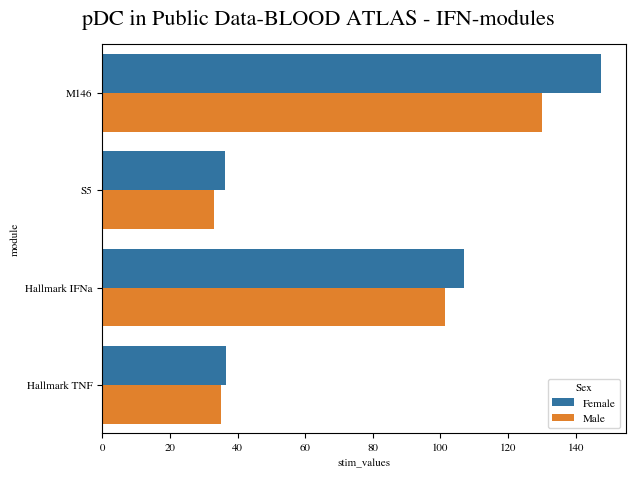

In [5]:
new_rc_params = {
"font.family": 'Times',
"font.size": 8,
"font.serif": [],
"svg.fonttype": 'none'} #to store text as text, not as path
plt.rcParams.update(new_rc_params)

sns.barplot(y = 'module', x = 'stim_values', data = barplot_df_bloodatlas, hue = 'Sex')
plt.suptitle('pDC in Public Data-BLOOD ATLAS - IFN-modules', fontsize = 16)
plt.tight_layout()

#plt.savefig('figures/publicly_available_data_hallmarkIFNaPDCs.png')

In [6]:
df_bloodatlas_pvalues

,t_statistic,pvalue
M146,2.593119,0.010854
S5,0.688963,0.492352
Hallmark IFNa,2.322319,0.022127
Hallmark TNF,0.337178,0.736649


In [7]:
### Blood Atlas - Monocytes ###
#data from Blood Atlas of COVID-19 https://pubmed.ncbi.nlm.nih.gov/35216673/
blood_atlas = sc.read('insert data from BloodAtlas pathway here')

blood_atlas = blood_atlas[blood_atlas.obs.development_stage.isin(['1-year-old human stage', '2-year-old human stage', '3-year-old human stage'])] #young age only
blood_atlas = blood_atlas[blood_atlas.obs.Source.str.contains('COVID')]
blood_atlas = blood_atlas[blood_atlas.obs.major_subset.isin(['cMono', 'ncMono'])]
blood_atlas = blood_atlas[blood_atlas.obs.TimeSinceOnset < 10]
sc.pp.normalize_total(blood_atlas, target_sum = 1e4)
blood_atlas.var = blood_atlas.var.set_index('feature_name')

stim_M_bloodatlas = blood_atlas[(blood_atlas.obs.sex == 'male')].to_df()
stim_F_bloodatlas = blood_atlas[(blood_atlas.obs.sex == 'female')].to_df()


In [8]:
barplot_df_bloodatlas, df_bloodatlas_pvalues = get_btm_df_withPvalues(stim_F_bloodatlas, stim_M_bloodatlas, 'TNF')

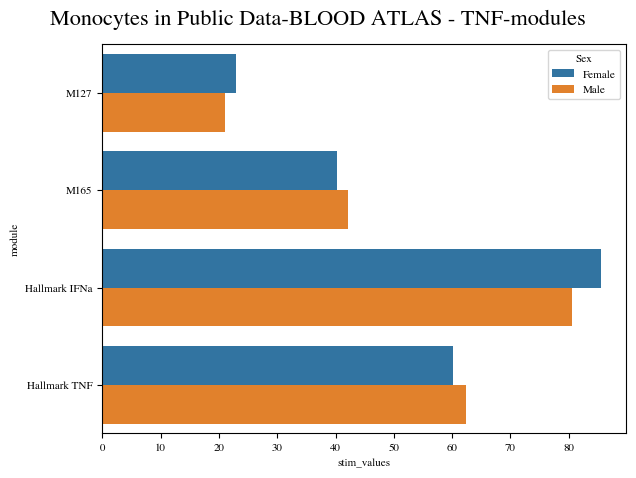

In [9]:
new_rc_params = {
"font.family": 'Times',
"font.size": 8,
"font.serif": [],
"svg.fonttype": 'none'} #to store text as text, not as path
plt.rcParams.update(new_rc_params)

sns.barplot(y = 'module', x = 'stim_values', data = barplot_df_bloodatlas, hue = 'Sex')
plt.suptitle('Monocytes in Public Data-BLOOD ATLAS - TNF-modules', fontsize = 16)
plt.tight_layout()

#plt.savefig('figures/publicly_available_data_hallmarkTNFaMonocytes.svg')

In [10]:
df_bloodatlas_pvalues

,t_statistic,pvalue
M127,15.428316,2.641532e-53
M165,4.126685,3.699627e-05
Hallmark IFNa,17.808091,3.086700e-70
Hallmark TNF,-3.596563,3.234568e-04


# Figure 5c - pDCs and Monocytes from Covid-patients (Zhao et al)

In [11]:
ct = 'pDC' 

#downloaded data from Zhao et al: https://www.nature.com/articles/s41392-021-00753-7
cnp = sc.read('insert data from Zhao et al pathway here')

cnp = cnp[cnp.obs.age < 50]
cnp = cnp[cnp.obs.days < 8]
sc.pp.normalize_total(cnp, target_sum = 1e4)
stim_M_cnp = cnp[(cnp.obs.sex == 'M') & (cnp.obs.celltype_lowerres.str.contains(ct))].to_df()
stim_F_cnp = cnp[(cnp.obs.sex == 'F') & (cnp.obs.celltype_lowerres.str.contains(ct))].to_df()


In [12]:
barplot_df_cnp, df_cnp_pvalues = get_btm_df_withPvalues(stim_F_cnp, stim_M_cnp, 'IFN')

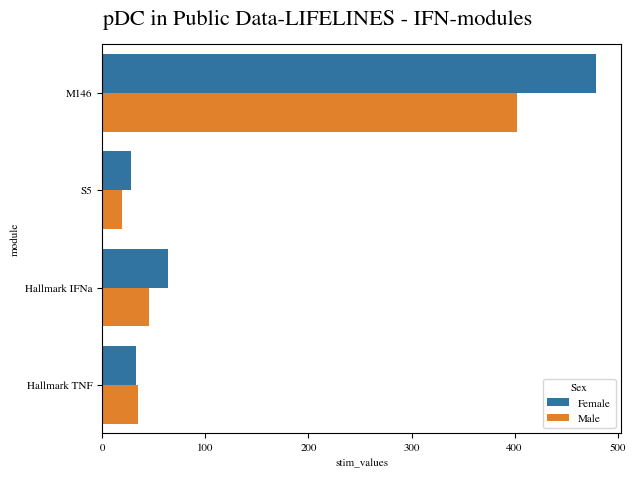

In [13]:
new_rc_params = {
"font.family": 'Times',
"font.size": 8,
"font.serif": [],
"svg.fonttype": 'none'} #to store text as text, not as path
plt.rcParams.update(new_rc_params)

sns.barplot(y = 'module', x = 'stim_values', data = barplot_df_cnp, hue = 'Sex')
plt.suptitle('pDC in Public Data-LIFELINES - IFN-modules', fontsize = 16)
plt.tight_layout()

#plt.savefig('figures/publicly_available_data_hallmarkIFNaPDCs.png')

In [14]:
df_cnp_pvalues

,t_statistic,pvalue
M146,0.290053,0.774492
S5,1.353149,0.189750
Hallmark IFNa,2.152584,0.042581
Hallmark TNF,-1.186396,0.248121


In [15]:
#### CNP - Monocytes ####
ct = 'Monocytes' 
#downloaded data from Zhao et al: https://www.nature.com/articles/s41392-021-00753-7
cnp = sc.read('insert data from Zhao et al pathway here')

cnp = cnp[cnp.obs.age < 50]
cnp = cnp[cnp.obs.days < 10]
sc.pp.normalize_total(cnp, target_sum = 1e4)
stim_M_cnp = cnp[(cnp.obs.sex == 'M') & (cnp.obs.celltype_lowerres.str.contains(ct))].to_df()
stim_F_cnp = cnp[(cnp.obs.sex == 'F') & (cnp.obs.celltype_lowerres.str.contains(ct))].to_df()

In [16]:
barplot_df_cnp, df_cnp_pvalues = get_btm_df_withPvalues(stim_F_cnp, stim_M_cnp, 'TNF')

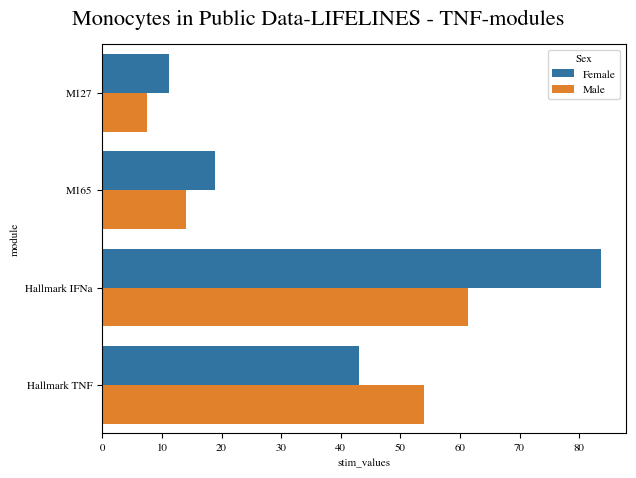

In [17]:
new_rc_params = {
"font.family": 'Times',
"font.size": 8,
"font.serif": [],
"svg.fonttype": 'none'} #to store text as text, not as path
plt.rcParams.update(new_rc_params)

sns.barplot(y = 'module', x = 'stim_values', data = barplot_df_cnp, hue = 'Sex')
plt.suptitle('Monocytes in Public Data-LIFELINES - TNF-modules', fontsize = 16)
plt.tight_layout()

#plt.savefig('figures/publicly_available_data_hallmarkIFNaPDCs.svg')

In [18]:
df_cnp_pvalues

,t_statistic,pvalue
M127,14.269000,3.235292e-45
M165,14.088985,3.770751e-44
Hallmark IFNa,20.233296,3.276699e-87
Hallmark TNF,-13.504420,9.013296e-41


# Figure 5d - pDC and Monocytes in LifeLines cohort (Oelen et al)

In [82]:
### EGAD pDC ###
ct = 'pDC'
#Download data from https://www.nature.com/articles/s41467-022-30893-5
egad = sc.read('insert data from Oelen et al pathway')
egad = egad[egad.obs.timepoint.str.contains('3hCA')]
sc.pp.normalize_total(egad, target_sum = 1e4)
egad.obs.age_fixed = egad.obs.age_fixed.astype(int)
egad = egad[egad.obs.age_fixed < 50]
dfm = egad[(egad.obs.sex == 'M') & (egad.obs.celltype_sub == ct)].to_df()
dff = egad[(egad.obs.sex == 'F') & (egad.obs.celltype_sub == ct)].to_df()

In [83]:
barplot_df_egad, df_egad_pvalues = get_btm_df_withPvalues(dff, dfm, 'IFN')

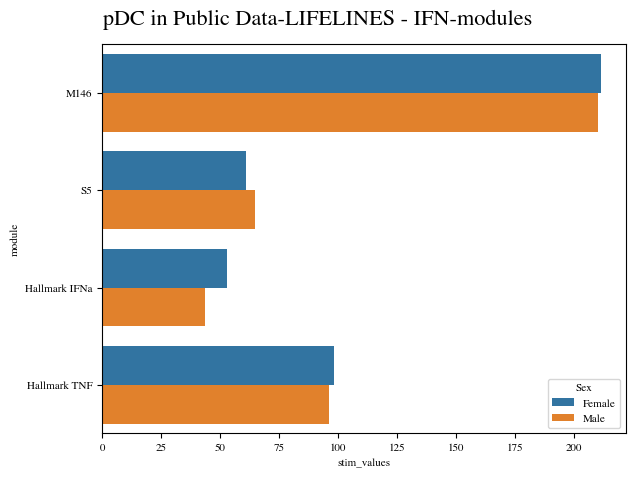

In [84]:
new_rc_params = {
"font.family": 'Times',
"font.size": 8,
"font.serif": [],
"svg.fonttype": 'none'} #to store text as text, not as path
plt.rcParams.update(new_rc_params)

sns.barplot(y = 'module', x = 'stim_values', data = barplot_df_egad, hue = 'Sex')
plt.suptitle('pDC in Public Data-LIFELINES - IFN-modules', fontsize = 16)
plt.tight_layout()

#plt.savefig('figures/publicly_available_data_hallmarkIFNaPDCs.svg')

In [85]:
df_egad_pvalues

,t_statistic,pvalue
M146,-0.373521,0.709065
S5,0.053410,0.957446
Hallmark IFNa,2.283325,0.023218
Hallmark TNF,0.656628,0.512001


In [60]:
### EGAD Monocyte MTB-stim ###
ct = 'monocyte'
#Download data from https://www.nature.com/articles/s41467-022-30893-5
egad = sc.read('insert data from Oelen et al pathway')
egad = egad[egad.obs.timepoint.str.contains('MTB')] 
sc.pp.normalize_total(egad, target_sum = 1e4)
egad.obs.age_fixed = egad.obs.age_fixed.astype(int)
egad = egad[egad.obs.age_fixed < 50]
dfm = egad[(egad.obs.sex == 'M') & (egad.obs.celltype == ct)].to_df()
dff = egad[(egad.obs.sex == 'F') & (egad.obs.celltype == ct)].to_df()


In [61]:
barplot_df_egad, df_egad_pvalues = get_btm_df_withPvalues(dff, dfm, 'TNF')

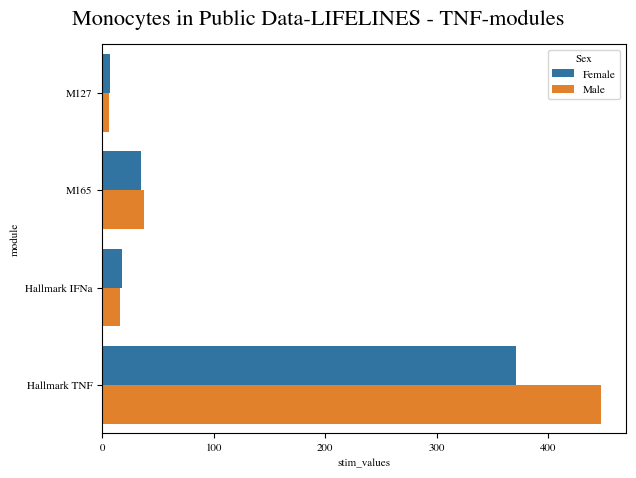

In [62]:
new_rc_params = {
"font.family": 'Times',
"font.size": 8,
"font.serif": [],
"svg.fonttype": 'none'} #to store text as text, not as path
plt.rcParams.update(new_rc_params)

sns.barplot(y = 'module', x = 'stim_values', data = barplot_df_egad, hue = 'Sex')
plt.suptitle('Monocytes in Public Data-LIFELINES - TNF-modules', fontsize = 16)
plt.tight_layout()

#plt.savefig('figures_temp_delete/publicly_available_data_hallmarkTNFaMonocytes_MTBstim.png')

In [63]:
df_egad_pvalues

,t_statistic,pvalue
M127,3.091759,1.993969e-03
M165,-5.143313,2.738747e-07
Hallmark IFNa,5.167491,2.407827e-07
Hallmark TNF,-16.935606,1.187317e-63


# Figure 5e and 5 f - SLAMF7 in Monocytes

In [88]:
hallmark_tnf = ["GEM", "CCL20", "MSC", "IL23A", "CD80", "TUBB2A", "IL1A", "IL6", "FOSL1", "DUSP4", "INHBA", "PLAU", "CD83",
                "F3", "CXCL2", "EDN1", "GFPT2","TRAF1", "SOCS3", "RCAN1","ZC3H12A", "PMEPA1", "SPSB1", "GADD45B", "GADD45A", "BTG3",
                "PPP1R15A", "SERPINB2", "ID2", "BIRC3", "SOD2", "HES1", "TNFAIP6", "G0S2", "EIF1", "CD44", "MAFF", "ICAM1", "MAP3K8",
               "YRDC", "BCL2A1", "DUSP2", "PFKFB3", "LAMB3", "EFNA1", "CLCF1", "TNIP2", "ZBTB10", "EGR2", "IL1B", "MAP2K3", "NR4A2",
               "CCND1", "TNFAIP2", "TNF", "TNFAIP8", "NFKB2", "KYNU", "TNFAIP3", "BCL6", "CEBPB", "NAMPT", "SLC2A6", "CCRL2"]

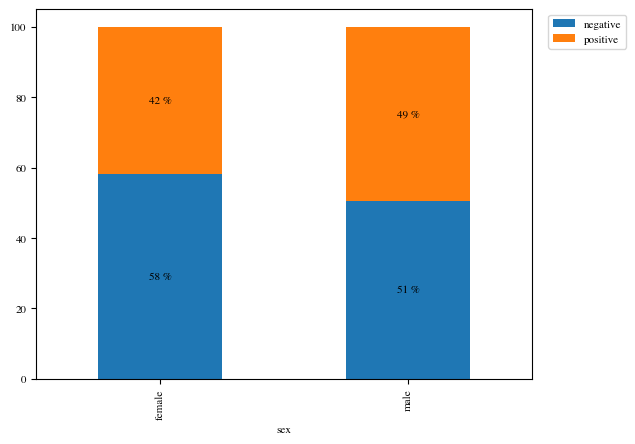

In [89]:
new_rc_params = {
"font.family": 'Times',
"font.size": 8,
"font.serif": [],
"svg.fonttype": 'none'} #to store text as text, not as path
plt.rcParams.update(new_rc_params)

##################################################
#### EGAD  - SLAMF7 proportions male vs female ####
##################################################
slamf7_hallmark = pd.DataFrame(columns = ['negative', 'positive', 'sex'])
ct = 'Monocyte'
#Download data from https://www.nature.com/articles/s41467-022-30893-5
egad = sc.read('insert data from Oelen et al pathway')

egad = egad[egad.obs.timepoint.str.contains('TB')]
sc.pp.normalize_total(egad, target_sum = 1e4)
egad.obs.age_fixed = egad.obs.age_fixed.astype(int)
egad.obs.celltype = egad.obs.celltype.replace('monocyte', 'Monocyte')
egad = egad[egad.obs.age_fixed < 50]
stim_v1_egad = egad[(egad.obs.sex == 'F') & (egad.obs.celltype == ct)].to_df()
stim_v2_egad = egad[(egad.obs.sex == 'M') & (egad.obs.celltype == ct)].to_df()

hallmark = hallmark_tnf
gene = 'SLAMF7'
v1_slamf7_n = stim_v1_egad[stim_v1_egad[gene] == 0]
v1_slamf7_p = stim_v1_egad[stim_v1_egad[gene] > 0]

v2_slamf7_n = stim_v2_egad[stim_v2_egad[gene] == 0]
v2_slamf7_p = stim_v2_egad[stim_v2_egad[gene] > 0]    

slamf7_hallmark.loc['female'] = [(len(v1_slamf7_n)/len(stim_v1_egad))*100,(len(v1_slamf7_p)/len(stim_v1_egad))*100,'female']
slamf7_hallmark.loc['male'] = [(len(v2_slamf7_n)/len(stim_v2_egad))*100,(len(v2_slamf7_p)/len(stim_v2_egad))*100, 'male']


ax = slamf7_hallmark.plot(kind = 'bar', x = 'sex', stacked = True)
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.text(x+width/2, 
            y+height/2, 
            '{:.0f} %'.format(height), 
            horizontalalignment='center', 
            verticalalignment='center')
    
plt.legend(bbox_to_anchor=(1.2, 1))
#plt.savefig('figures/publicly_available_data/SLAMF7proportions_Monocytes_LifeLines.svg', bbox_inches = 'tight')

Text(0.5, 1.0, 'SLAMF7(+) vs SLAMF7(-) Monocyte TNF hallmark')

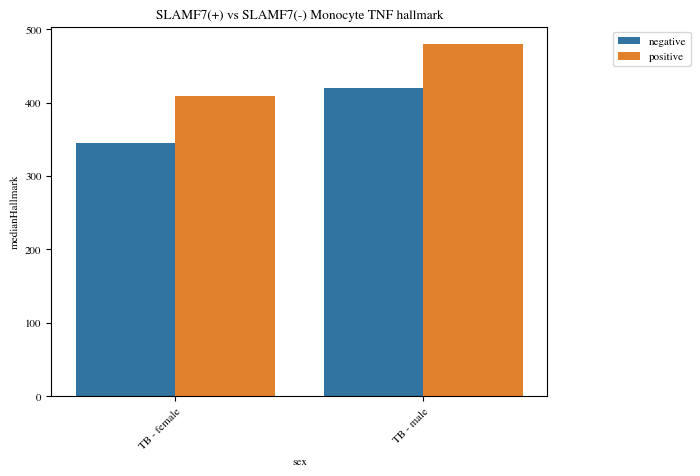

In [90]:
new_rc_params = {
"font.family": 'Times',
"font.size": 8,
"font.serif": [],
"svg.fonttype": 'none'} #to store text as text, not as path
plt.rcParams.update(new_rc_params)

##################################################
#### EGAD  - SLAMF7 pos vs neg in HallmarkTNF ####
##################################################
slamf7_hallmark = pd.DataFrame(columns = ['medianHallmark','posOrNeg', 'sex'])
ct = 'Monocyte'

#Download data from https://www.nature.com/articles/s41467-022-30893-5
egad = sc.read('insert data from Oelen et al pathway')

egad = egad[egad.obs.timepoint.str.contains('TB')]
sc.pp.normalize_total(egad, target_sum = 1e4)
egad.obs.age_fixed = egad.obs.age_fixed.astype(int)
egad.obs.celltype = egad.obs.celltype.replace('monocyte', 'Monocyte')
egad = egad[egad.obs.age_fixed < 50]
stim_v1_egad = egad[(egad.obs.sex == 'F') & (egad.obs.celltype == ct)].to_df()
stim_v2_egad = egad[(egad.obs.sex == 'M') & (egad.obs.celltype == ct)].to_df()

hallmark = hallmark_tnf
gene = 'SLAMF7'
v1_slamf7_n = stim_v1_egad[stim_v1_egad[gene] == 0]
v1_slamf7_p = stim_v1_egad[stim_v1_egad[gene] > 0]

v2_slamf7_n = stim_v2_egad[stim_v2_egad[gene] == 0]
v2_slamf7_p = stim_v2_egad[stim_v2_egad[gene] > 0]    

slamf7_hallmark.loc['female - negative'] = [np.median(np.sum(v1_slamf7_n[v1_slamf7_n.columns[v1_slamf7_n.columns.isin(hallmark)]], axis = 1)), 'negative', 'TB - female']
slamf7_hallmark.loc['female - positive'] = [np.median(np.sum(v1_slamf7_p[v1_slamf7_p.columns[v1_slamf7_p.columns.isin(hallmark)]], axis = 1)), 'positive', 'TB - female']

slamf7_hallmark.loc['male - negative'] = [np.median(np.sum(v2_slamf7_n[v2_slamf7_n.columns[v2_slamf7_n.columns.isin(hallmark)]], axis = 1)), 'negative', 'TB - male']
slamf7_hallmark.loc['male - positive'] = [np.median(np.sum(v2_slamf7_p[v2_slamf7_p.columns[v2_slamf7_p.columns.isin(hallmark)]], axis = 1)), 'positive', 'TB - male']

slamf7_props = slamf7_hallmark#pd.concat([slamf7_hallmark.loc[['LPS-V2negative', 'LPS-V2positive', 'LPS-V1negative', 'LPS-V1positive']], slamf7_hallmark_EGAD_TB, slamf7_hallmark_COVID])

sns.barplot(slamf7_props, x = 'sex', y = 'medianHallmark', hue = 'posOrNeg') #rasterized to make "less vectors" as svg - maybe easier to work with in Illustrator?
plt.xticks(rotation = 45, ha = 'right', rotation_mode="anchor")
plt.legend(bbox_to_anchor=(1.3, 1))
plt.title('SLAMF7(+) vs SLAMF7(-) '+ct+ ' TNF hallmark')

#plt.savefig('figures/publicly_available_data/SLAMF7hallmarkTNF_Monocytes_LifeLines.svg')

In [92]:
female_pos = np.sum(v1_slamf7_p[v1_slamf7_p.columns[v1_slamf7_p.columns.isin(hallmark)]], axis = 1)
female_neg = np.sum(v1_slamf7_n[v1_slamf7_n.columns[v1_slamf7_n.columns.isin(hallmark)]], axis = 1)

male_pos = np.sum(v2_slamf7_p[v2_slamf7_p.columns[v2_slamf7_p.columns.isin(hallmark)]], axis = 1)
male_neg = np.sum(v2_slamf7_n[v2_slamf7_n.columns[v2_slamf7_n.columns.isin(hallmark)]], axis = 1)

In [94]:
print(scipy.stats.ttest_ind(np.log1p(female_pos), np.log1p(female_neg)))
print(scipy.stats.ttest_ind(np.log1p(male_pos), np.log1p(male_neg)))

Ttest_indResult(statistic=11.651727388509524, pvalue=4.670064137926737e-31)
Ttest_indResult(statistic=9.976403678672257, pvalue=2.81635609794493e-23)


# Figure 5g and 5h - NK cells MTB-stimuli and IFNg expression in LifeLines (EGAD)

In [64]:
### EGAD NK ###
#Download data from https://www.nature.com/articles/s41467-022-30893-5
egad = sc.read('insert data from Oelen et al pathway')

sc.pp.normalize_total(egad, target_sum = 1e4)
egad.obs.age_fixed = egad.obs.age_fixed.astype(int)
egad = egad[egad.obs.age_fixed < 50]

egad_3hmtb = egad[egad.obs.timepoint.str.contains('3hMTB')] #For NK
egad_24hmtb = egad[egad.obs.timepoint.str.contains('24hMTB')] #For NK


dfm_3h = egad_3hmtb[(egad_3hmtb.obs.sex == 'M') & (egad_3hmtb.obs.celltype == 'NK')].to_df()
dff_3h = egad_3hmtb[(egad_3hmtb.obs.sex == 'F') & (egad_3hmtb.obs.celltype == 'NK')].to_df()

dfm_24h = egad_24hmtb[(egad_24hmtb.obs.sex == 'M') & (egad_24hmtb.obs.celltype == 'NK')].to_df()
dff_24h = egad_24hmtb[(egad_24hmtb.obs.sex == 'F') & (egad_24hmtb.obs.celltype == 'NK')].to_df()


Ttest_indResult(statistic=7.767769784619205, pvalue=9.639032981727553e-15)
Ttest_indResult(statistic=-4.027968530440523, pvalue=5.713542745095849e-05)


Text(0.5, 0.98, 'Mean Gene Expression - LifeLines\nNK in 3h and 24hTB-stim')

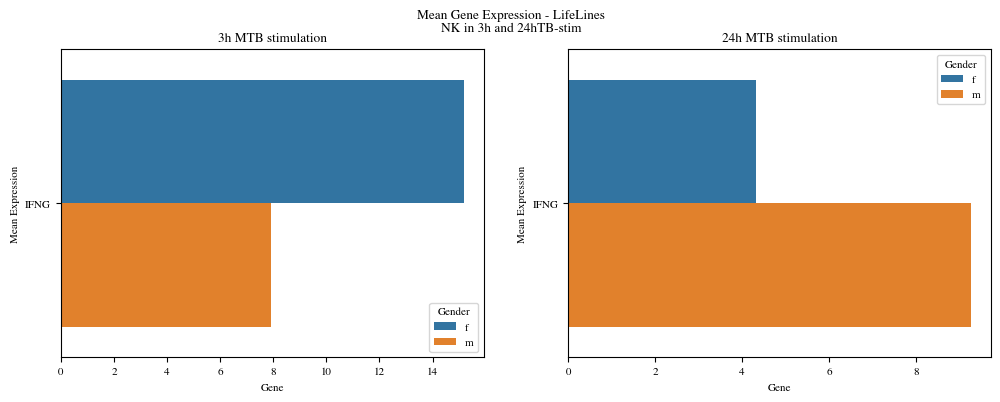

In [81]:
fig, ax = plt.subplots(1,2, figsize = (12,4))
# Data for the genes and their corresponding means for males and females
ifng_m = np.mean(dfm_3h['IFNG'])
ifng_f = np.mean(dff_3h['IFNG'])

data = {
    'Gene': ['IFNG', 'IFNG'],
    'Gender': ['m', 'f'],
    'Mean': [ifng_m, ifng_f]
}

# Creating a DataFrame
df = pd.DataFrame(data)
sns.barplot(y='Gene', x='Mean', hue='Gender', data=df, ax = ax[0], hue_order = ['f', 'm'])
ax[0].set_title('3h MTB stimulation')
ax[0].set_xlabel('Gene')
ax[0].set_ylabel('Mean Expression')

print(scipy.stats.ttest_ind(np.log1p(dff_3h['IFNG']), np.log1p(dfm_3h['IFNG'])))

ifng_m = np.mean(dfm_24h['IFNG'])
ifng_f = np.mean(dff_24h['IFNG'])

data = {
    'Gene': ['IFNG', 'IFNG'],
    'Gender': ['m', 'f'],
    'Mean': [ifng_m, ifng_f]
}

# Creating a DataFrame
df = pd.DataFrame(data)
sns.barplot(y='Gene', x='Mean', hue='Gender', data=df, ax = ax[1], hue_order = ['f', 'm'])
ax[1].set_title('24h MTB stimulation')
ax[1].set_xlabel('Gene')
ax[1].set_ylabel('Mean Expression')

print(scipy.stats.ttest_ind(np.log1p(dff_24h['IFNG']), np.log1p(dfm_24h['IFNG'])))
      
plt.suptitle('Mean Gene Expression - LifeLines\nNK in 3h and 24hTB-stim')

#plt.savefig('LifeLines_NK-24hTBstim_IFNG_SLAMF7_genes_barplot.pdf', bbox_inches = 'tight')